<a href="https://colab.research.google.com/github/lemair/CoronaVirus-App/blob/main/ARIMA_Forecasting_for_COVID_19_Confirmed_Cases.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading data...
Data loaded successfully.
Preprocessing data...
Data preprocessing complete.
Time series shape (Global Cases): (1143,)
Time series head (Global Cases):
2020-01-22     557
2020-01-23     657
2020-01-24     944
2020-01-25    1437
2020-01-26    2120
Freq: D, dtype: int64

Generating heatmap for daily new cases of top countries (excluding special regions)...


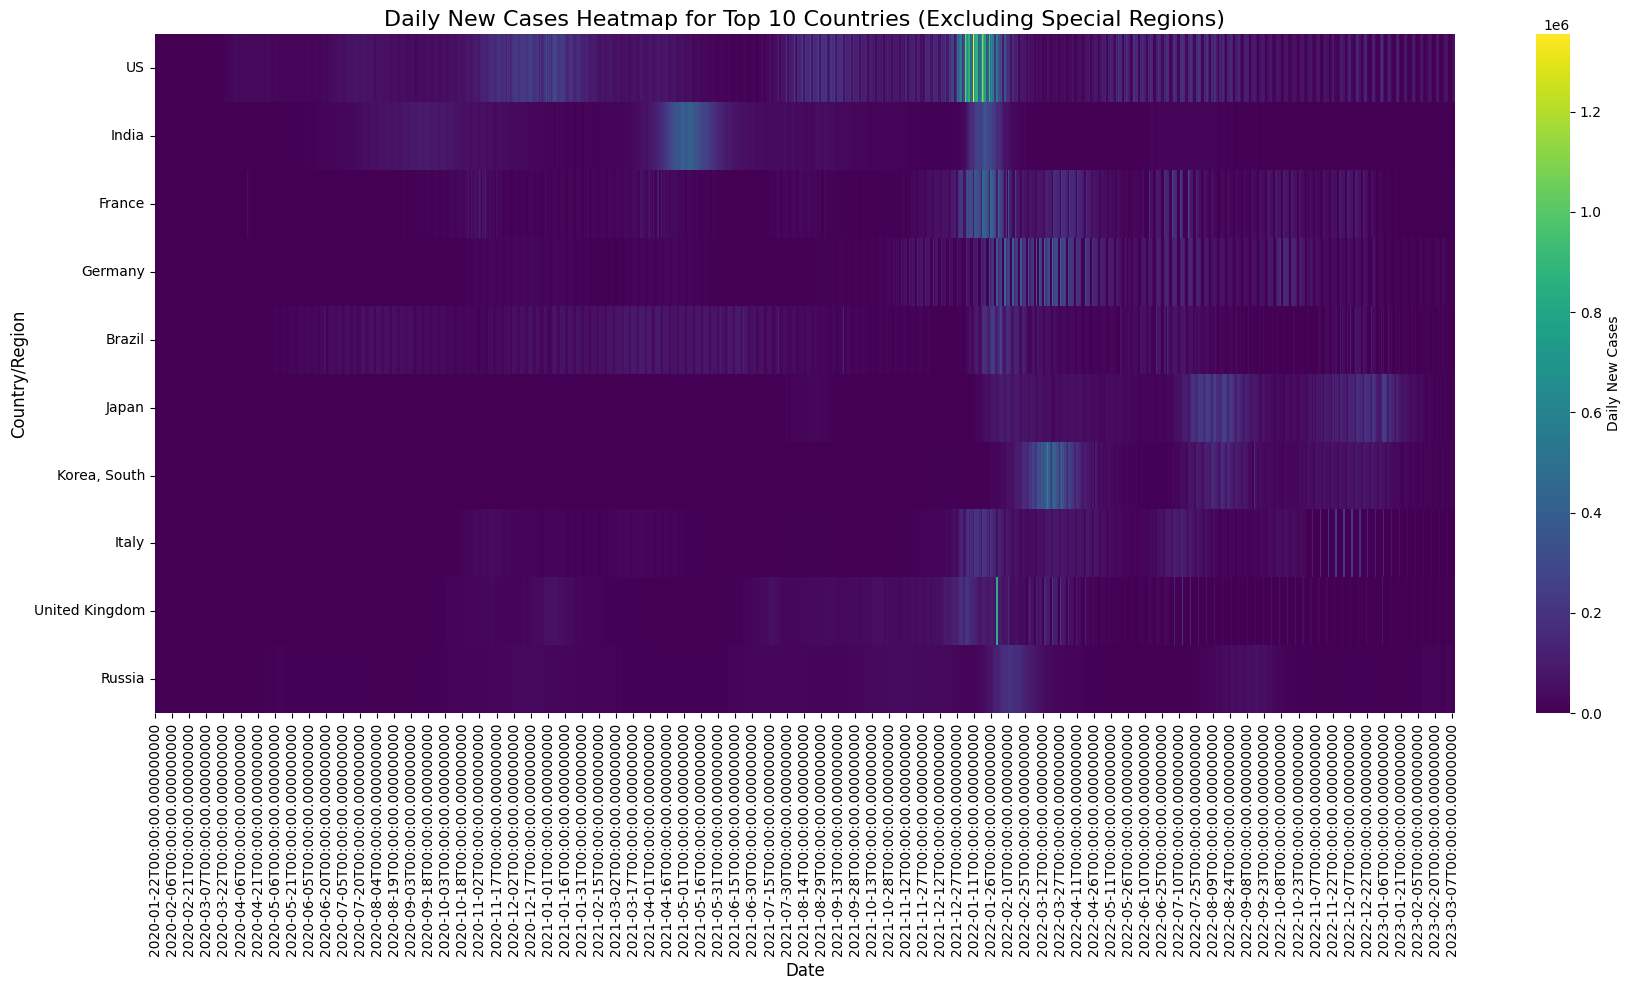

Heatmap generated.

Checking for stationarity using Augmented Dickey-Fuller test (ADF)...

ADF test for original Global Cases:
ADF Statistic: 0.0081
p-value: 0.9592
#Lags Used: 21.0000
Number of Observations Used: 1121.0000
Conclusion: Weak evidence against the null hypothesis (Ho), so the series is non-stationary.

Taking first difference to achieve stationarity (daily new cases)...

ADF test for Differenced Global Cases:
ADF Statistic: -3.0446
p-value: 0.0309
#Lags Used: 20.0000
Number of Observations Used: 1121.0000
Conclusion: Strong evidence against the null hypothesis (Ho), so the series is stationary.

Starting grid search for optimal ARIMA (p,d,q) parameters...
Training data size: 914
Test data size: 229

Grid search complete. Best ARIMANone with AIC: inf


TypeError: cannot unpack non-iterable NoneType object

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Import for potential future use or debugging
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
import warnings
import itertools

# Suppress warnings to keep the output clean, especially from statsmodels
warnings.filterwarnings("ignore")

# 1. Load the dataset
print("Loading data...")
try:
    df = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/refs/heads/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
    print("Data loaded successfully.")
except Exception as e:
    print(f"Error loading data: {e}")
    # It's good practice to exit if data loading fails, as subsequent steps depend on it.
    exit()

# 2. Preprocess the data
print("Preprocessing data...")
# Drop unnecessary columns (Lat, Long, Province/State) as they are not needed for global or country-level aggregation
df_processed = df.drop(columns=['Lat', 'Long', 'Province/State'])

# Aggregate by 'Country/Region' to get total cases per country over time
# NaN values in the raw daily case columns are treated as 0 during sum aggregation,
# which is appropriate for cumulative case data where missing implies no cases reported.
df_agg = df_processed.groupby('Country/Region').sum()

# Transpose the dataframe so dates become the index, which is standard for time series analysis
df_ts = df_agg.T

# Convert index to datetime objects for proper time series operations
df_ts.index = pd.to_datetime(df_ts.index)

# Sum across all countries to get the global confirmed cases time series
global_cases = df_ts.sum(axis=1)

# Resample to daily frequency ('D') to ensure continuity and fill any missing dates
# with the last valid observation using forward fill ('ffill'). This is crucial for forecasting.
global_cases = global_cases.asfreq('D')
global_cases = global_cases.fillna(method='ffill')

print("Data preprocessing complete.")
print(f"Time series shape (Global Cases): {global_cases.shape}")
print(f"Time series head (Global Cases):\n{global_cases.head()}")


# --- Generate Heatmap for Top Countries with exclusions ---
print("\nGenerating heatmap for daily new cases of top countries (excluding special regions)...")

# Define a list of non-country/special regions to exclude from the heatmap
# These are typically cruise ships or specific event-related entries that skew country analysis
exclude_regions = [
    'Diamond Princess cruise ship',
    'MS Zaandam',
    'Summer Olympics 2020',
    'Winter Olympics 2022',
    'Grand Princess',
    'Cases on an international conveyance Japan',
    'Canada' # Excluded based on the original user prompt
]

# Filter df_ts to exclude the specified regions before calculating top N countries
# `errors='ignore'` prevents an error if a column from `exclude_regions` isn't found
columns_to_drop = [col for col in exclude_regions if col in df_ts.columns]
df_ts_filtered_for_heatmap = df_ts.drop(columns=columns_to_drop, errors='ignore')

# Calculate total cases for each country (excluding special regions) to find the top N
# Use the last row (most recent total cases) to rank countries
country_total_cases = df_ts_filtered_for_heatmap.iloc[-1].sort_values(ascending=False)
top_n_countries = country_total_cases.head(10).index.tolist() # Get the names of the top 10 countries

# Filter df_ts_filtered_for_heatmap for these top countries for further analysis
df_top_countries = df_ts_filtered_for_heatmap[top_n_countries]

# Calculate daily new cases for selected countries by taking the difference between consecutive days.
# `fillna(0)` handles the first row (which becomes NaN after diff), and `clip(lower=0)` ensures no negative values.
daily_new_cases_top_countries = df_top_countries.diff().fillna(0).clip(lower=0)

# Create the heatmap
plt.figure(figsize=(18, 10)) # Adjust figure size for better readability
sns.heatmap(daily_new_cases_top_countries.T, cmap='viridis', cbar_kws={'label': 'Daily New Cases'})
plt.title('Daily New Cases Heatmap for Top 10 Countries (Excluding Special Regions)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Country/Region', fontsize=12)
plt.yticks(rotation=0) # Ensure country names are horizontal
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

print("Heatmap generated.")
# --- End of Heatmap addition ---


# 3. Check for stationarity and difference the data if necessary
print("\nChecking for stationarity using Augmented Dickey-Fuller test (ADF)...")
def adf_test(series):
    """
    Performs the Augmented Dickey-Fuller test on a time series
    to check for stationarity.
    """
    result = adfuller(series.dropna()) # .dropna() handles any initial NaNs
    labels = ['ADF Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']
    for value, label in zip(result, labels):
        print(f'{label}: {value:.4f}') # Format to 4 decimal places for clarity
    if result[1] <= 0.05: # p-value <= 0.05 indicates stationarity
        print("Conclusion: Strong evidence against the null hypothesis (Ho), so the series is stationary.")
    else:
        print("Conclusion: Weak evidence against the null hypothesis (Ho), so the series is non-stationary.")

# Test stationarity for the original global cases data
print("\nADF test for original Global Cases:")
adf_test(global_cases)

print("\nTaking first difference to achieve stationarity (daily new cases)...")
# The first difference represents daily new cases.
# .dropna() removes the first NaN created by diff().
# .clip(lower=0) ensures non-negative daily new cases.
global_cases_diff = global_cases.diff().dropna().clip(lower=0)

# Test stationarity for the differenced global cases data
print("\nADF test for Differenced Global Cases:")
adf_test(global_cases_diff)

# 4. Determine the ARIMA model orders (p, d, q) through grid search
print("\nStarting grid search for optimal ARIMA (p,d,q) parameters...")

# Define the ranges for p, d, q parameters to try
# p: auto-regressive (AR) order
# d: integrated (I) order (number of differencing operations)
# q: moving average (MA) order
p_values = range(0, 5) # p can be 0, 1, 2 (adjusted range to speed up and commonly effective values)
d_values = range(0, 5) # d can be 0, 1 (as we likely need 1 differencing for stationarity)
q_values = range(0, ) # q can be 0, 1, 2 (adjusted range)

# Generate all different combinations of p, d, q
pdq_combinations = list(itertools.product(p_values, d_values, q_values))

best_aic = float("inf") # Initialize with a very large value to find the minimum AIC
best_pdq = None
best_model_fit = None # Store the best fitted model to avoid refitting

# Split data into training (80%) and testing (20%) sets for model validation during grid search
train_size = int(len(global_cases) * 0.8)
train_data, test_data = global_cases[0:train_size], global_cases[train_size:]

print(f"Training data size: {len(train_data)}")
print(f"Test data size: {len(test_data)}")

# Iterate over all possible (p, d, q) combinations
for order in pdq_combinations:
    try:
        # Fit ARIMA model on the training data with the current order
        model = ARIMA(train_data, order=order)
        model_fit = model.fit()

        # Check if the current model's AIC is better than the best found so far
        if model_fit.aic < best_aic:
            best_aic = model_fit.aic
            best_pdq = order
            best_model_fit = model_fit # Update the best fitted model
        # Uncomment the line below to see AIC for each combination during search
        # print(f'ARIMA{order} AIC: {model_fit.aic:.2f}')
    except Exception as e:
        # print(f'ARIMA{order} failed: {e}') # Uncomment for detailed errors during search
        continue # Continue to the next combination if fitting fails

print(f"\nGrid search complete. Best ARIMA{best_pdq} with AIC: {best_aic:.2f}")

# Use the best parameters found from the grid search
p, d, q = best_pdq
print(f"\nUsing optimal ARIMA({p},{d},{q}) model for final forecast.")

# 5. Fit the ARIMA model with optimal parameters
print("Fitting ARIMA model with optimal parameters on the training data...")
try:
    # Use the best_model_fit already obtained from the grid search.
    # This avoids refitting the same model if it was successfully found.
    if best_model_fit is None: # Fallback in case no model could be fitted during grid search
        model = ARIMA(train_data, order=(p, d, q))
        model_fit = model.fit()
    else:
        model_fit = best_model_fit # Use the pre-fitted best model

    print("ARIMA model fitted successfully with optimal parameters.")
    # Display the summary of the fitted model for detailed statistics
    print(model_fit.summary())
except Exception as e:
    print(f"Error fitting ARIMA model with optimal parameters: {e}")
    print("Consider adjusting p, d, q values or simplifying the model configuration.")
    exit() # Exit if final model fitting fails, as predictions depend on it.

# 6. Make predictions on the test set
print("\nMaking predictions...")
# Define the start and end indices for the forecast based on the training and global data length
start_forecast = len(train_data)
end_forecast = len(global_cases) - 1 # Last index of the original global cases data

# Generate predictions using the fitted model
# `dynamic=False` means predictions for each step use actual values up to the previous step.
# If `dynamic=True`, predictions for each step use previous *forecasted* values.
forecast = model_fit.predict(start=start_forecast, end=end_forecast, dynamic=False)

# Assign the index of the test_data to the forecast for proper plotting alignment
forecast.index = test_data.index
# Ensure no negative forecasted cases, as case counts cannot be negative
forecast[forecast < 0] = 0

print("Predictions generated.")
print(f"Forecasted values head:\n{forecast.head()}")

# 7. Evaluate performance with Mean Squared Error (MSE)
print("\nEvaluating model performance...")
# Align actual values with the forecast's index to ensure correct comparison
actual_values = test_data.loc[forecast.index]
mse = mean_squared_error(actual_values, forecast)
print(f"Mean Squared Error (MSE) on the test set: {mse:.2f}")

# 8. Visualize the results
print("\nVisualizing actual vs. forecasted values...")
plt.figure(figsize=(15, 7)) # Set figure size for better visualization
plt.plot(train_data.index, train_data, label='Training Data (Actual Cases)', color='blue')
plt.plot(test_data.index, test_data, label='Actual Cases (Test Data)', color='green')
plt.plot(forecast.index, forecast, label='ARIMA Forecast', color='red', linestyle='--')
plt.title('ARIMA Forecast vs. Actual Global Confirmed COVID-19 Cases', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Confirmed Cases', fontsize=12)
plt.legend(fontsize=10) # Add legend for clarity
plt.grid(True) # Add grid for easier reading of values
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

print("\nARIMA forecasting complete. The plot shows the training data, actual test data, and the ARIMA forecast.")
print(f"The Mean Squared Error (MSE) on the test set is: {mse:.2f}")


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# Load the dataset
df = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/refs/heads/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")

# Aggregate global confirmed cases
# Drop unnecessary columns and sum across countries for each date
df_time_series = df.drop(columns=['Province/State', 'Country/Region', 'Lat', 'Long']).sum().reset_index()
df_time_series.columns = ['Date', 'ConfirmedCases']

# Convert 'Date' to datetime and set as index
df_time_series['Date'] = pd.to_datetime(df_time_series['Date'])
df_time_series = df_time_series.set_index('Date')

# Calculate daily new cases instead of cumulative cases for better stationarity
# Cumulative data often has a strong trend, making it non-stationary.
# Differencing once will give daily new cases, which might be more suitable for ARIMA.
df_time_series['DailyNewCases'] = df_time_series['ConfirmedCases'].diff().fillna(0) # Fill NaN from diff with 0

# It's better to work with daily new cases if you want to model short-term fluctuations
# If you want to model the cumulative trend, you'll likely need more differencing.
# For this example, let's stick with DailyNewCases
time_series_data = df_time_series['DailyNewCases']

# You might want to remove initial zeros if they are just reporting zeros
# time_series_data = time_series_data[time_series_data > 0] # Be careful with this, check your data first

<ipython-input-1-3216342624>:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_time_series['Date'] = pd.to_datetime(df_time_series['Date'])


ADF test for Daily New Cases:
ADF Statistic: -3.043423
p-value: 0.031033
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


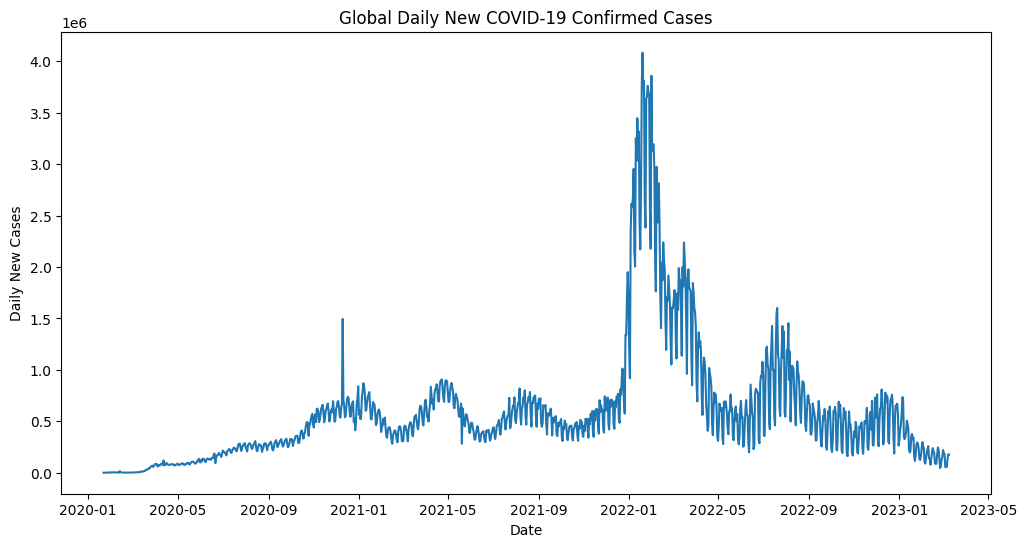

In [ ]:
# Perform ADF test
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

print("ADF test for Daily New Cases:")
adf_test(time_series_data)

# Plot to visually inspect
plt.figure(figsize=(12, 6))
plt.plot(time_series_data)
plt.title('Global Daily New COVID-19 Confirmed Cases')
plt.xlabel('Date')
plt.ylabel('Daily New Cases')
plt.show()

# If p-value is > 0.05, the series is likely non-stationary and needs differencing.
# The 'd' parameter in ARIMA(p,d,q) handles this differencing.
# We already did one differencing to get DailyNewCases.
# If 'DailyNewCases' is still non-stationary, you might need to difference it again (d=2 in ARIMA).

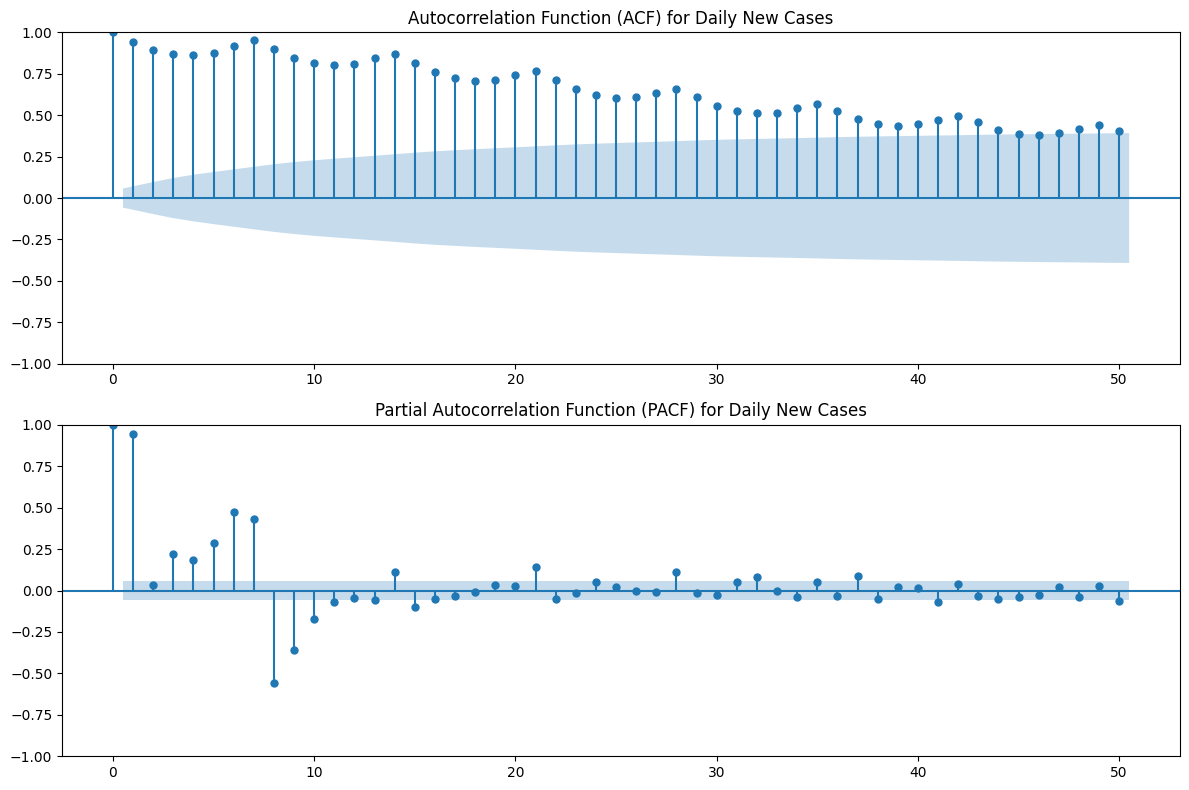

ModuleNotFoundError: No module named 'pmdarima'

In [ ]:
# Plot ACF and PACF to determine p and q
plt.figure(figsize=(12, 8))
plt.subplot(211)
plot_acf(time_series_data.dropna(), ax=plt.gca(), lags=50) # dropna() because diff creates NaN
plt.title('Autocorrelation Function (ACF) for Daily New Cases')

plt.subplot(212)
plot_pacf(time_series_data.dropna(), ax=plt.gca(), lags=50)
plt.title('Partial Autocorrelation Function (PACF) for Daily New Cases')
plt.tight_layout()
plt.show()

# Based on ACF/PACF plots, you'll choose initial p and q values.
# For example, if ACF trails off and PACF cuts off after lag 2, it suggests AR(2), so p=2.
# If PACF trails off and ACF cuts off after lag 1, it suggests MA(1), so q=1.
# Often, for real-world data, this isn't perfectly clear, and you might need to try a few combinations.

# A common approach is to use auto_arima from the pmdarima library, which automatically finds the best p, d, q.
# If you don't have it, install it: pip install pmdarima
from pmdarima import auto_arima

# This can take a while to run
# model_auto_arima = auto_arima(time_series_data,
#                               seasonal=False, # Set to True if you suspect seasonality (e.g., weekly patterns)
#                               suppress_warnings=True,
#                               stepwise=True)
# print(model_auto_arima.summary())
# You would get the optimal (p,d,q) from this output.
# For COVID data, there might be strong seasonality (e.g., weekly reporting patterns), so seasonal=True
# might be beneficial, leading to a SARIMA model.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:          DailyNewCases   No. Observations:                  914
Model:                 ARIMA(2, 2, 4)   Log Likelihood              -12410.985
Date:                Sun, 15 Jun 2025   AIC                          24835.969
Time:                        22:09:09   BIC                          24869.679
Sample:                    01-22-2020   HQIC                         24848.838
                         - 07-23-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1600      0.026     -6.165      0.000      -0.211      -0.109
ar.L2         -0.7725      0.022    -35.744      0.000      -0.815      -0.730
ma.L1         -0.8552      0.035    -24.150      0.0

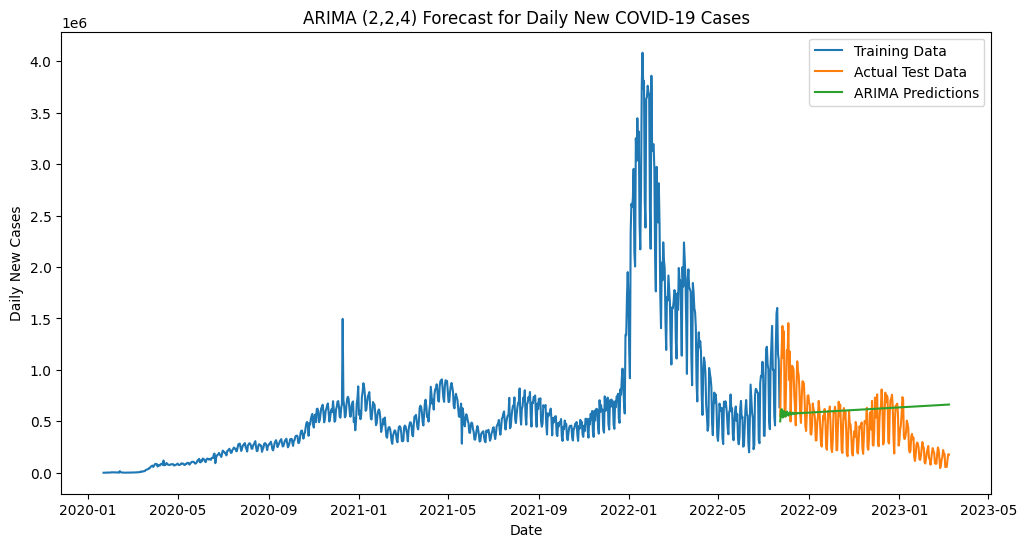

RMSE: 332173.146
MAE: 271890.513


In [ ]:
# Split data into training and testing sets (optional but highly recommended)
train_size = int(len(time_series_data) * 0.8)
train_data, test_data = time_series_data[0:train_size], time_series_data[train_size:]

# Fit the ARIMA model
# Replace p, d, q with your determined orders
# Let's use (5,0,5) as a placeholder. You'll need to optimize this.
# For cumulative data, a common starting point might be (5,1,0) or (1,1,0)
# For daily new cases, 'd' is often 0 if you've already differenced.
order = (2, 2, 4) # Example orders, you need to determine this based on analysis

try:
    model = ARIMA(train_data.dropna(), order=order) # dropna() is crucial here
    model_fit = model.fit()
    print(model_fit.summary())

    # Make predictions
    start_index = len(train_data)
    end_index = len(time_series_data) - 1
    predictions = model_fit.predict(start=start_index, end=end_index)

    # Plot results
    plt.figure(figsize=(12, 6))
    plt.plot(train_data.index, train_data, label='Training Data')
    plt.plot(test_data.index, test_data, label='Actual Test Data')
    plt.plot(predictions.index, predictions, label='ARIMA Predictions')
    plt.title(f'ARIMA ({order[0]},{order[1]},{order[2]}) Forecast for Daily New COVID-19 Cases')
    plt.xlabel('Date')
    plt.ylabel('Daily New Cases')
    plt.legend()
    plt.show()

    # Evaluate the model (e.g., using Mean Squared Error or Mean Absolute Error)
    from sklearn.metrics import mean_squared_error, mean_absolute_error
    rmse = np.sqrt(mean_squared_error(test_data, predictions))
    mae = mean_absolute_error(test_data, predictions)
    print(f'RMSE: {rmse:.3f}')
    print(f'MAE: {mae:.3f}')

except Exception as e:
    print(f"An error occurred during ARIMA model fitting or prediction: {e}")
    print("Consider adjusting the ARIMA (p,d,q) orders or checking data stationarity.")

<ipython-input-40-2112155444>:21: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_time_series.index = pd.to_datetime(df_time_series.index)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


X_train shape: (903, 14, 1)
y_train shape: (903,)
X_test shape: (226, 14, 1)
y_test shape: (226,)
Epoch 1/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - loss: 0.0133 - val_loss: 0.0046
Epoch 2/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0039 - val_loss: 0.0041
Epoch 3/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0027 - val_loss: 0.0046
Epoch 4/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0036 - val_loss: 0.0042
Epoch 5/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0049 - val_loss: 0.0044
Epoch 6/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0028 - val_loss: 0.0047
Epoch 7/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0035 - val_loss: 0.0045
Epoch 8/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0029 - val_loss: 0.0046
Epoch 9/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0028 - val_loss: 0.0046
Epoch 10/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0029 - val_loss: 0.0046
Epoch 11/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 1

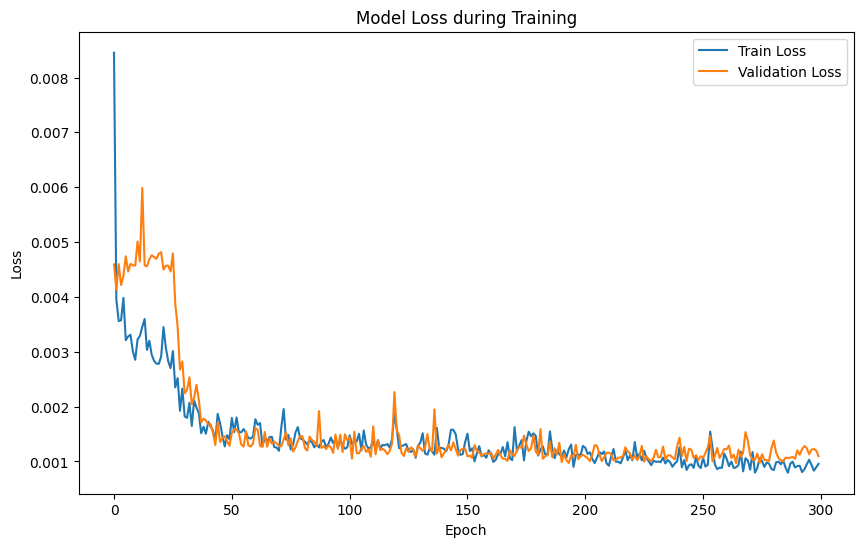

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
Root Mean Squared Error (RMSE): 100265.92
Mean Absolute Error (MAE): 71647.78


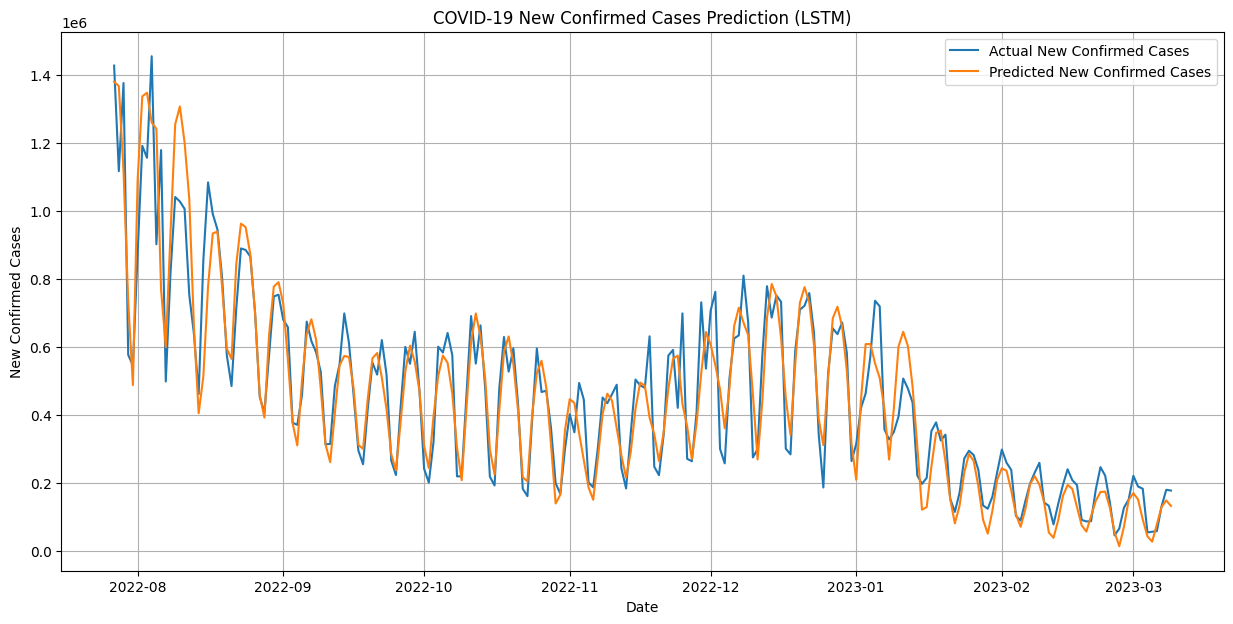

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Predicted new confirmed cases for the next day: 82196


In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import Dropout
import math

# URL of the dataset
url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/refs/heads/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"

# 1. Data Loading and Preprocessing
df = pd.read_csv(url)

# Let's focus on global confirmed cases for simplicity, summing up all provinces/states
# We need to drop 'Province/State', 'Country/Region', 'Lat', 'Long' to get only date columns
df_time_series = df.drop(columns=['Province/State', 'Country/Region', 'Lat', 'Long']).sum(axis=0)
df_time_series = pd.DataFrame(df_time_series, columns=['Confirmed'])
df_time_series.index = pd.to_datetime(df_time_series.index)

# Calculate daily new confirmed cases (often better for forecasting than cumulative)
df_time_series['New_Confirmed'] = df_time_series['Confirmed'].diff().fillna(0)
# Ensure no negative new cases (can happen due to data corrections)
df_time_series['New_Confirmed'] = df_time_series['New_Confirmed'].apply(lambda x: max(0, x))

# Use 'New_Confirmed' for forecasting
data = df_time_series['New_Confirmed'].values.reshape(-1, 1)

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# 2. Create Sequences for LSTM
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        # Extract the sequence of n_steps
        seq_x = data[i:(i + n_steps), 0]
        # The target is the next value after the sequence
        seq_y = data[i + n_steps, 0]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

n_steps = 14 # Number of previous time steps to use as input

X, y = create_sequences(scaled_data, n_steps)

# Reshape X for LSTM input (samples, timesteps, features)
X = X.reshape(X.shape[0], X.shape[1], 1)

# 3. Split Data into Training and Testing Sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

# 4. Build the LSTM Model
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(n_steps, 1))) # First LSTM layer
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=False)) # Second LSTM layer
model.add(Dropout(0.2))
model.add(Dense(units=1)) # Output layer

# 5. Compile and Train the Model
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, epochs=300, batch_size=32, validation_split=0.1, verbose=1)

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss during Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 6. Make Predictions and Evaluate
predictions = model.predict(X_test)

# Inverse transform the predictions and actual values
predictions = scaler.inverse_transform(predictions)
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate evaluation metrics
rmse = math.sqrt(mean_squared_error(y_test_original, predictions))
mae = mean_absolute_error(y_test_original, predictions)

print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")

# Visualize actual vs. predicted (on the test set)
plt.figure(figsize=(15, 7))
plt.plot(df_time_series.index[train_size + n_steps:], y_test_original, label='Actual New Confirmed Cases')
plt.plot(df_time_series.index[train_size + n_steps:], predictions, label='Predicted New Confirmed Cases')
plt.title('COVID-19 New Confirmed Cases Prediction (LSTM)')
plt.xlabel('Date')
plt.ylabel('New Confirmed Cases')
plt.legend()
plt.grid(True)
plt.show()

# Example of forecasting future values (one step ahead)
# Get the last 'n_steps' values from the original scaled data
last_n_steps = scaled_data[-n_steps:]
last_n_steps = last_n_steps.reshape(1, n_steps, 1)

# Predict the next day
next_day_prediction_scaled = model.predict(last_n_steps)
next_day_prediction_original = scaler.inverse_transform(next_day_prediction_scaled)

print(f"Predicted new confirmed cases for the next day: {next_day_prediction_original[0][0]:.0f}")

<ipython-input-50-204069987>:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_time_series.index = pd.to_datetime(df_time_series.index)
<ipython-input-50-204069987>:25: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_time_series['Smoothed'] = df_time_series['New_Confirmed'].rolling(7).mean().fillna(method='bfill')
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/365
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 0.2342 - val_loss: 0.0133
Epoch 2/365
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0075 - val_loss: 1.5702e-04
Epoch 3/365
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0042 - val_loss: 2.4681e-04
Epoch 4/365
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0035 - val_loss: 1.2254e-04
Epoch 5/365
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0032 - val_loss: 1.3459e-04
Epoch 6/365
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0030 - val_loss: 1.0144e-04
Epoch 7/365
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0028 - val_loss: 9.7849e-05
Epoch 8/365
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0026 - val_loss: 2.8998e-04
Epoch 9/365
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0025 - val_loss: 3.7017e-04
Epoch 10/365
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0030 - val_loss: 4.1401e-04
Epoch 11/365
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0029 - val_loss: 1.0141e-04
Epoch 12/365

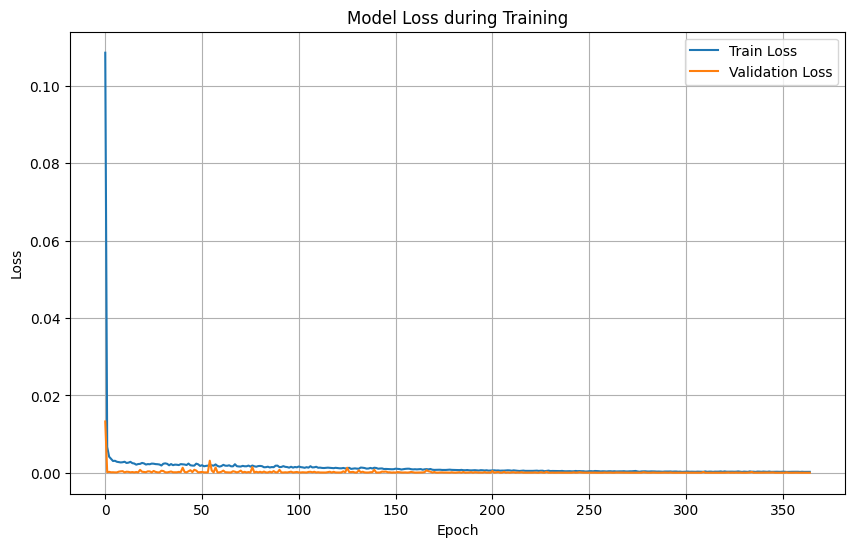

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step
Root Mean Squared Error (RMSE): 19615.10
Mean Absolute Error (MAE): 13481.78
Mean Absolute Percentage Error (MAPE): 2.78%


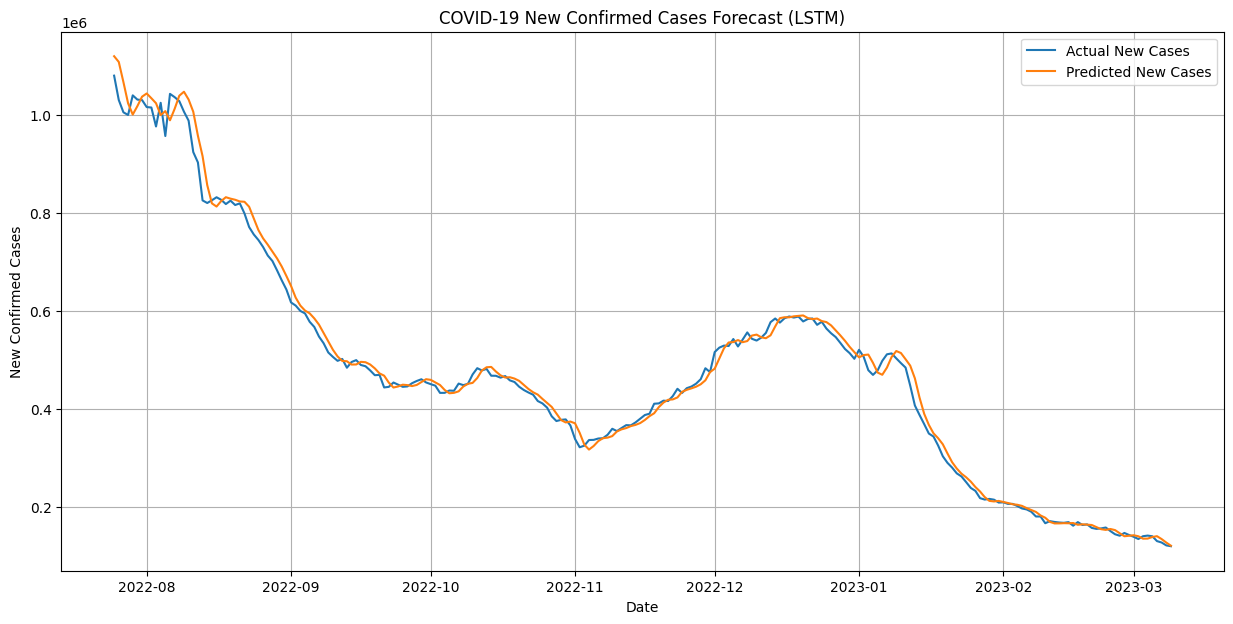

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Predicted new confirmed cases for next day: 117473


In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import math

# Load dataset
url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/refs/heads/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
df = pd.read_csv(url)

# Preprocess: sum across all countries to get global total
df_time_series = df.drop(columns=['Province/State', 'Country/Region', 'Lat', 'Long']).sum(axis=0)
df_time_series = pd.DataFrame(df_time_series, columns=['Confirmed'])
df_time_series.index = pd.to_datetime(df_time_series.index)

# Calculate new daily confirmed cases
df_time_series['New_Confirmed'] = df_time_series['Confirmed'].diff().fillna(0)
df_time_series['New_Confirmed'] = df_time_series['New_Confirmed'].apply(lambda x: max(0, x))

# Smooth the data with 7-day moving average
df_time_series['Smoothed'] = df_time_series['New_Confirmed'].rolling(7).mean().fillna(method='bfill')

# Log transform to reduce scale volatility
df_time_series['Log_Smoothed'] = np.log1p(df_time_series['Smoothed'])

# Scale data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_time_series['Log_Smoothed'].values.reshape(-1, 1))

# Create sequences
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i+n_steps, 0])
        y.append(data[i+n_steps, 0])
    return np.array(X), np.array(y)

n_steps = 7
X, y = create_sequences(scaled_data, n_steps)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Train-test split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build model
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(n_steps, 1)))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Train model
history = model.fit(X_train, y_train, epochs=365, batch_size=32,
                    validation_split=0.1, callbacks=[early_stop], verbose=1)

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss during Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Make predictions
predictions_scaled = model.predict(X_test)

# Inverse transform (log1p + scaler)
predictions = np.expm1(scaler.inverse_transform(predictions_scaled))
y_test_original = np.expm1(scaler.inverse_transform(y_test.reshape(-1, 1)))

# Evaluation metrics
rmse = math.sqrt(mean_squared_error(y_test_original, predictions))
mae = mean_absolute_error(y_test_original, predictions)
mape = np.mean(np.abs((y_test_original - predictions) / y_test_original)) * 100

print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# Visualize predictions
test_dates = df_time_series.index[n_steps + train_size:]
plt.figure(figsize=(15, 7))
plt.plot(test_dates, y_test_original, label='Actual New Cases')
plt.plot(test_dates, predictions, label='Predicted New Cases')
plt.title('COVID-19 New Confirmed Cases Forecast (LSTM)')
plt.xlabel('Date')
plt.ylabel('New Confirmed Cases')
plt.legend()
plt.grid(True)
plt.show()

# Forecast next day
last_n_steps = scaled_data[-n_steps:].reshape(1, n_steps, 1)
next_day_scaled = model.predict(last_n_steps)
next_day = np.expm1(scaler.inverse_transform(next_day_scaled))
print(f"Predicted new confirmed cases for next day: {next_day[0][0]:.0f}")


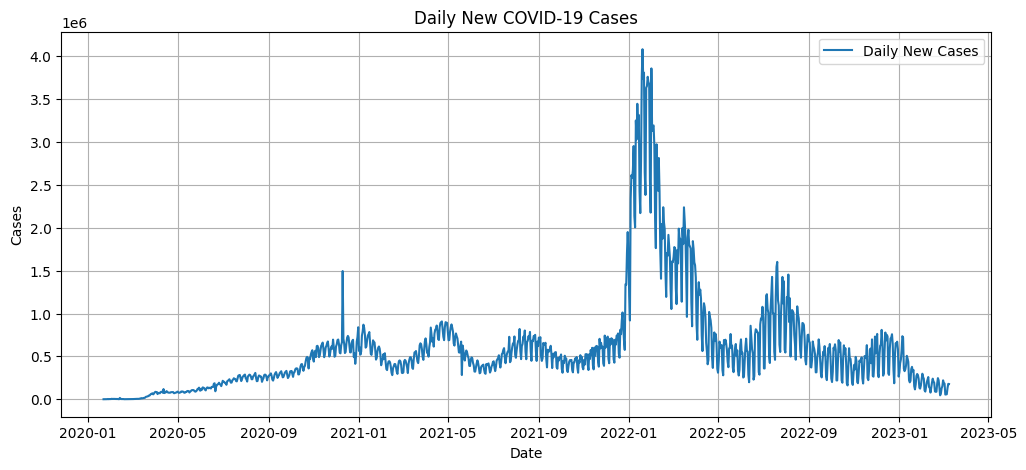

In [51]:
plt.figure(figsize=(12, 5))
plt.plot(df_time_series['New_Confirmed'], label='Daily New Cases')
plt.title("Daily New COVID-19 Cases")
plt.xlabel("Date")
plt.ylabel("Cases")
plt.legend()
plt.grid(True)
plt.show()


<ipython-input-8-543493120>:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_time_series.index = pd.to_datetime(df_time_series.index)
<ipython-input-8-543493120>:26: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_time_series['Smoothed'] = df_time_series['New_Confirmed'].rolling(window=7).mean().fillna(method='bfill')


Epoch 0 | Train Loss: 0.660237 | Val Loss: 0.333948
Epoch 10 | Train Loss: 0.187384 | Val Loss: 0.141477
Epoch 20 | Train Loss: 0.041050 | Val Loss: 0.020675
Epoch 30 | Train Loss: 0.026121 | Val Loss: 0.006837
Epoch 40 | Train Loss: 0.026229 | Val Loss: 0.004685
Epoch 50 | Train Loss: 0.026013 | Val Loss: 0.003965
Epoch 60 | Train Loss: 0.024863 | Val Loss: 0.004551
Epoch 70 | Train Loss: 0.023590 | Val Loss: 0.003517
Epoch 80 | Train Loss: 0.018875 | Val Loss: 0.002716
Epoch 90 | Train Loss: 0.004103 | Val Loss: 0.009394
Epoch 100 | Train Loss: 0.004380 | Val Loss: 0.004102
Epoch 110 | Train Loss: 0.002748 | Val Loss: 0.001007
Epoch 120 | Train Loss: 0.001689 | Val Loss: 0.001077
Epoch 130 | Train Loss: 0.001003 | Val Loss: 0.000414
Epoch 140 | Train Loss: 0.000779 | Val Loss: 0.000295
Epoch 150 | Train Loss: 0.000687 | Val Loss: 0.000444
Epoch 160 | Train Loss: 0.000652 | Val Loss: 0.000259
Epoch 170 | Train Loss: 0.000619 | Val Loss: 0.000265
Epoch 180 | Train Loss: 0.000602 | Val 

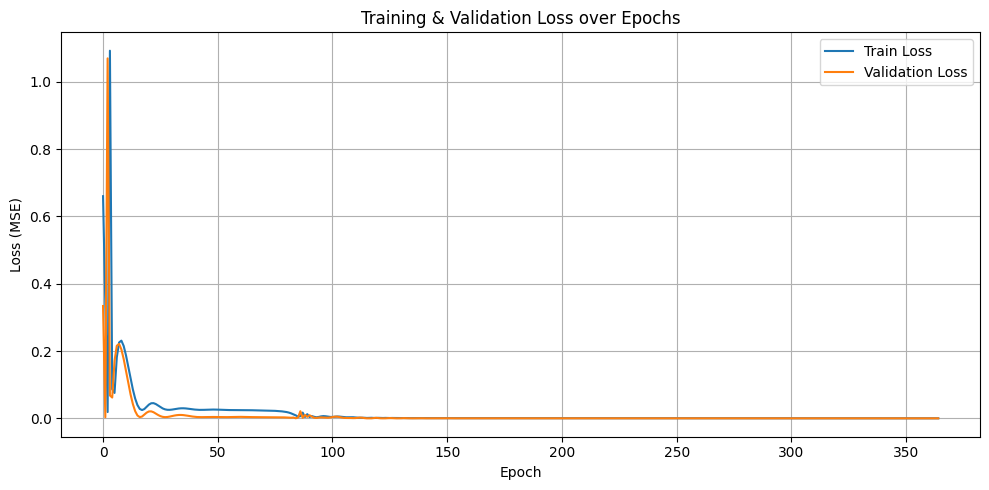

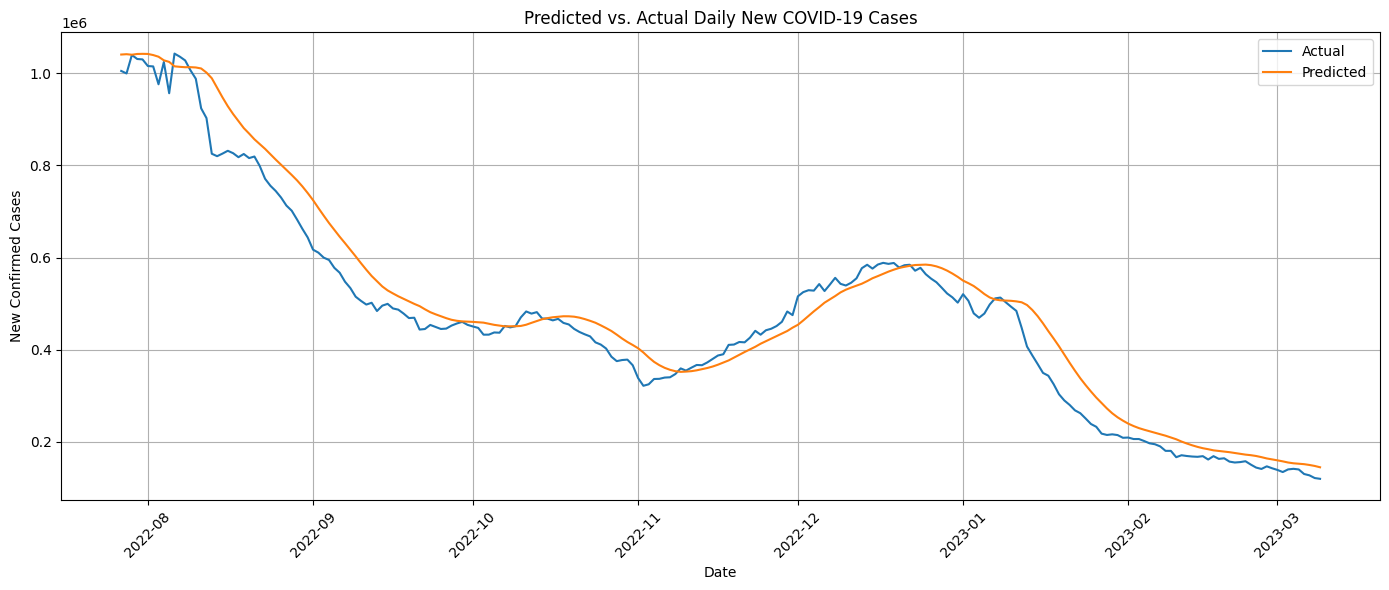

✅ Quantized model saved as 'quantized_lstm_forecaster.pth'


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

# ------------------------ 1. Load & Preprocess Data ------------------------ #
# Load COVID-19 data
url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/refs/heads/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
df = pd.read_csv(url)

# Aggregate global daily confirmed cases
df_time_series = df.drop(columns=['Province/State', 'Country/Region', 'Lat', 'Long']).sum(axis=0)
df_time_series = pd.DataFrame(df_time_series, columns=['Confirmed'])
df_time_series.index = pd.to_datetime(df_time_series.index)

# Compute new daily cases
df_time_series['New_Confirmed'] = df_time_series['Confirmed'].diff().fillna(0)
df_time_series['New_Confirmed'] = df_time_series['New_Confirmed'].apply(lambda x: max(0, x))

# Apply 7-day moving average smoothing
df_time_series['Smoothed'] = df_time_series['New_Confirmed'].rolling(window=7).mean().fillna(method='bfill')

# Log transform
df_time_series['Log_Smoothed'] = np.log1p(df_time_series['Smoothed'])

# Scale
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_time_series['Log_Smoothed'].values.reshape(-1, 1)).flatten()

# ------------------------ 2. Sequence Creation ------------------------ #
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i+n_steps])
        y.append(data[i+n_steps])
    return np.array(X), np.array(y)

n_steps = 14
X, y = create_sequences(scaled_data, n_steps)

# Train/test split
train_size = int(len(X) * 0.8)
X_train = torch.tensor(X[:train_size], dtype=torch.float32).unsqueeze(-1)
y_train = torch.tensor(y[:train_size], dtype=torch.float32)
X_test = torch.tensor(X[train_size:], dtype=torch.float32).unsqueeze(-1)
y_test = torch.tensor(y[train_size:], dtype=torch.float32)

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X_train, X_test, y_train, y_test = X_train.to(device), X_test.to(device), y_train.to(device), y_test.to(device)

# ------------------------ 3. LSTM Model Definition ------------------------ #
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

model = LSTMModel().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# ------------------------ 4. Training Loop ------------------------ #
train_losses, val_losses = [], []
epochs = 365

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    pred = model(X_train).squeeze()
    loss = criterion(pred, y_train)
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        val_pred = model(X_test).squeeze()
        val_loss = criterion(val_pred, y_test)

    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    if epoch % 10 == 0 or epoch == epochs - 1:
        print(f"Epoch {epoch} | Train Loss: {loss.item():.6f} | Val Loss: {val_loss.item():.6f}")

# ------------------------ 5. Evaluation ------------------------ #
model.eval()
with torch.no_grad():
    predictions = model(X_test).squeeze().cpu().numpy()
    true_values = y_test.cpu().numpy()

# Inverse transform
predictions = np.expm1(scaler.inverse_transform(predictions.reshape(-1, 1)))
true_values = np.expm1(scaler.inverse_transform(true_values.reshape(-1, 1)))

rmse = math.sqrt(mean_squared_error(true_values, predictions))
mae = mean_absolute_error(true_values, predictions)
mape = np.mean(np.abs((true_values - predictions) / true_values)) * 100

print(f"\n✅ Evaluation Metrics:")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# ------------------------ 6. Plots ------------------------ #
# Loss curve
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Training & Validation Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Actual vs. Predicted
test_dates = df_time_series.index[n_steps + train_size:]

plt.figure(figsize=(14, 6))
plt.plot(test_dates, true_values, label='Actual')
plt.plot(test_dates, predictions, label='Predicted')
plt.title('Predicted vs. Actual Daily New COVID-19 Cases')
plt.xlabel('Date')
plt.ylabel('New Confirmed Cases')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ------------------------ 7. Quantization ------------------------ #
model_cpu = model.to('cpu')
quantized_model = torch.quantization.quantize_dynamic(
    model_cpu, {nn.LSTM, nn.Linear}, dtype=torch.qint8
)

torch.save(quantized_model.state_dict(), "quantized_lstm_forecaster.pth")
print("✅ Quantized model saved as 'quantized_lstm_forecaster.pth'")
